In [ ]:
import sklearn
sklearn.__version__

# Linear Regression and Regularization
Loosely following Chapter 10 of Python Machine Learning 3rd Edition, Raschka

>Disclaimer: Regression is a huge field. It is impossible to cover it all in one class (or even two).

<img src='files/diagrams/ols.png' style='width: 500px'>

[Image Source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html)

>For a sense of the depth and potential complexity of regression models, see [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)

## Agenda:
- What is least squares regression?  
- Closed-form solution.  
- Evaluation metrics.  
- Reading regression output.  
- p-value hacking.  
- Checking residuals.  
- Predicting new values.  
- Robust regression methods.  
- Multiple regression. 
- Strengths and weaknesses.  
- Pipelines.  
- Ridge.
- Gradient descent.  
- Lasso.



### Resources:
<br>[Ben Lambert's Derivation of OLS](https://www.youtube.com/watch?v=fb1CNQT-3Pg)
<br>[Andrew Ng Regression Lecture](https://www.youtube.com/watch?v=4b4MUYve_U8)
<br>[Cornell Regression Lecture](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote08.html)
<br>[Deriving Ridge Regression](https://stats.stackexchange.com/questions/69205/how-to-derive-the-ridge-regression-solution)
<br>[Common Pitfalls in Interpreting Coefficients](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)
<br>[HBR Article - Beware Spurious Correlations](https://hbr.org/2015/06/beware-spurious-correlations)
<br>[Saving your models with pickle](https://scikit-learn.org/stable/modules/model_persistence.html)


# Ordinary Least Squares (OLS) Linear Regression

>[All models are wrong, but some are useful.](https://en.wikipedia.org/wiki/All_models_are_wrong)
<br><br>George Box

Linear regression is one of the most popular, widely used, and foundational concepts in statistics, econometrics, and machine learning.  

Boils down having a numeric target value ($y$) we want to either predict or understand the variance drivers. We use data ($X$) we think impacts our target to understand the underlying **linear** relationship.

### Big Assumption: 
- The regression function $E(Y|X)$ is **linear** in the inputs $X_{1},\dots,X_{p}$
- Transformations can be applied to satisfy that requirement.

Typically will see it expressed as $y = \beta X$, or formally:  

$$
f(X)=\beta_{0}+\sum{X{j}\beta_{j}}
$$

- Linear model assumes the function is linear or reasonably linear.
- The true $\beta_{j}$'s are unknown parameters (coefficients/weights). 
- The features must be able to be represented within a non-null numeric matrix.


### Goal - Minimize the mean-squared error. Why?
Residuals will be positive and negative, need to penalize negative and positive equally.

Sum of errors: $\epsilon_{1} + \epsilon_{2} + \dots + \epsilon_{n}$  
RSS: $\epsilon_{1}^2 + \epsilon_{2}^2 + \dots + \epsilon_{n}^2$  
MSE: $\frac{1}{N}\sum{\epsilon_{i}^2}$


Most statistical programs solve for the $\beta$ values using plain old linear alegbra, in what is called the closed-form:  

$\hat\beta = (X^TX)^{-1}X^{T}y$

### Closed Form Derivation

$$RSS(\beta)=\sum{(y_{i}-f(x_{i}))^2}$$

$$=\sum(y_{i}-\beta_{0}-\sum{x_{ij}\beta{j}})^2$$

$(x_i,y_i)$ should be independent from other $(x_i,y_i)$'s  
- Time series models violate this without special treatment

We are seeking a $f(X)$ that minimizes the sum of squared residuals from $Y$:

<img src='files/diagrams/esl-3-1.png' style='width: 500px'>


[Image source: Elements of Statistical Learning, Figure 3.1](https://www.statlearning.com)

$$
RSS(\beta)=(y-X\beta)^T(y-X\beta)
$$

#### Differentiating:
$$
\frac{dRSS}{d\beta}=-2X^T(y-X\beta)
$$

#### And again:
$$
\frac{d^2RSS}{d\beta d \beta^T}=2X^TX
$$

#### Setting the first derivative to zero:
$$ 
X^T(y-X\beta)=0
$$

#### And we get:
$$
\hat{\beta}=(X^TX)^{-1}X^Ty
$$

#### And our predicted values are:
$$
\hat{y}=X\hat{\beta}
$$

#### And relates to $y$ by:
$$
y = \hat{y} + \epsilon =X\hat{\beta}+\epsilon 
$$

> Unique solution means we can derive with pure linear algebra, i.e., no need to use convergence algorithms.

## Slope and Intercept
### Remember in its simple form: $$y=mx+b$$

<img src='files/diagrams/slope.png' style="height: 200px;width: 200px;">

[Image source](https://en.wikipedia.org/wiki/Linear_regression#/media/File:Linear_least_squares_example2.png)

> Since we need an estimate for the intercept, we'll need to manually add the constant. Not all implementations do this automatically, e.g., statsmodels.

- Intercept: where the line go through the y-axis.  
- Slope: for a 1-unit change in x, y will increase by $\beta$


# Example - Credit Data
[Data from Elements of Statistical Learning](https://www.statlearning.com)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

credit = pd.read_csv('https://github.com/ekacar1/Data_for_Lectures/islr-credit.csv')
credit = credit.iloc[:, 1:]
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


## Find Function so $Rating=f(Limit)$
We'll need to convert the pandas objects to numpy arrays.

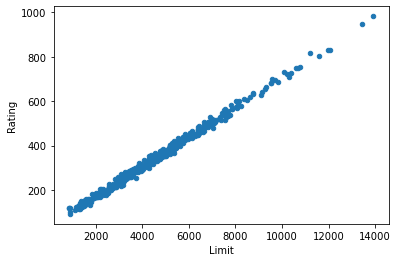

In [2]:
credit.plot.scatter(x='Limit', y='Rating')
plt.show()

## Regression using closed-form:

In [3]:
X = np.array(credit['Limit']).reshape(-1,1)
y = np.array(credit['Rating']).reshape(-1,1)

X.shape, y.shape

((400, 1), (400, 1))

And since we are going to implement a version, we'll need to manually add the constant for the intercept. Why?

$y=\beta_{0}+\beta_{i}x_{i}$

In [4]:
from numpy.linalg import inv

'''
- Manually adding the constant
- Sometimes this is done via the API (check the docs)
''' 
const = np.ones(shape=y.shape)
mat = np.concatenate( (const, X), axis=1)

# first 5 examples
mat[:5,:]

array([[1.000e+00, 3.606e+03],
       [1.000e+00, 6.645e+03],
       [1.000e+00, 7.075e+03],
       [1.000e+00, 9.504e+03],
       [1.000e+00, 4.897e+03]])

## Betas
We have a feature matrix that has 2 columns, so we'll get estimate for the constant ($\beta_{0}$) and the credit limit ($\beta_{1}$).

### Calculate the coefficient estimates
Recall $\hat\beta = (X^TX)^{-1}X^{T}y$

In [5]:
betas = inv(mat.transpose().dot(mat)).dot(mat.transpose()).dot(y)
b0, b1 = betas

print(f'Beta 0: {np.round(b0[0],3)}')
print(f'Beta 1: {np.round(b1[0],3)}')

Beta 0: 38.492
Beta 1: 0.067


### Predict $\hat{y}$ and plot the fit

$$
\begin{equation}
\hat{y}=\hat{\beta}X=
\hat{\beta_{0}}
\begin{pmatrix}
1 \\
\dots \\
1
\end{pmatrix}+
\hat{\beta_{1}}
\begin{pmatrix}
3606 \\
\dots \\
5524
\end{pmatrix}
\end{equation}
$$

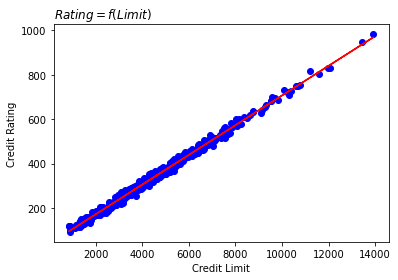

In [6]:
yhat = mat.dot(betas)

plt.plot(X, y, 'bo')
plt.plot(X, yhat, 'r')
plt.xlabel('Credit Limit')
plt.ylabel('Credit Rating')
plt.title('$Rating=f(Limit)$', loc='left')
plt.show()

# Quantifying fit with metrics
Common metrics:

### $R^2$ [Wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination)
$$1 - \frac{\sum (\hat {y}-y)^{2}}{\sum ({\bar y}-y)^{2}}$$

### Mean squared error (MSE) [Wikipedia](https://en.wikipedia.org/wiki/Mean_squared_error)
$$\frac{\sum (\hat {y}-y)^{2}}{n}$$

### Mean Absolute Error (MAE) [Wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_error)
$$1/n\sum |\hat {y}-y|$$

### Root mean squared error (RMSE) [Wikipedia](https://en.wikipedia.org/wiki/Root_mean_square)
$$\sqrt \frac{\sum (\hat {y}-y)^{2}}{n}$$

#### Notes:
- $r^2$ expresses the percent of variance explained (bound between 0% and 100%).  
- RMSE expresses the variance in unit terms.  
- MSE/RMSE are heavily influenced by outliers.  
- Usually RMSE is chosen for optimizing since it's an unbiased estimator.
- If there are a lot of outliers, MAE may be a better choice.

### Further reading:
[$r^2$ vs. RMSE](https://www.statology.org/rmse-vs-r-squared/)

# Intrepretability
A nice property of linear regression is the relatively simple intrepretations that can be drawn. The implementation in statsmodels includes all the output needed to evaluate and interpret model output.

[statsmodels OLS regression](https://www.statsmodels.org/stable/regression.html)

In [7]:
# betas we calculated:
betas.reshape(1,-1)[0]

array([38.49178871,  0.06682326])

statsmodels output:

In [8]:
import statsmodels.api as smf

simpleModel = smf.OLS(y, mat).fit()
print(simpleModel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 6.348e+04
Date:                Thu, 23 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:56:06   Log-Likelihood:                -1568.1
No. Observations:                 400   AIC:                             3140.
Df Residuals:                     398   BIC:                             3148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.4918      1.397     27.555      0.0

## Results Discussion:
- Overall $r^2$ of 99% - very strong linear relationship as we saw in the initial plot we created.  
- You can ignore the t-statistic on the constant - it isn't meaningful.  
- The t-statistic for the credit limit (x1) is very high (252), with a [p-value](https://en.wikipedia.org/wiki/P-value) of essentially 0 - recall a p-value is the probably that the effect we are seeing is by random chance.  
- We can conclude there is a very strong linear relationship.

### Further reading:
[Rethinking p-values](https://www.vox.com/2016/3/15/11225162/p-value-simple-definition-hacking)  
[Econometrics](https://en.wikipedia.org/wiki/Econometrics)

# A Note on p-Hacking

<img src='files/diagrams/bad-coef.png' style="width: 500px;">

>Taken from "Having Too Little or Too Much Time Is Linked to Lower Subjective Well-Being", Sharif et al.

# scikit-learn's LinearRegression
[scikit-learn's LinearRegression](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

This will probably be the implementation you'd want to use for comparing various regression models for prediction problems since the API will be similar.

scikit-learn is geared more towards prediction and won't have some of the friendly output that statsmodels has - if you are going for an intrepretation, you may be better off using statsmodels.

In [9]:
mat[:5]

array([[1.000e+00, 3.606e+03],
       [1.000e+00, 6.645e+03],
       [1.000e+00, 7.075e+03],
       [1.000e+00, 9.504e+03],
       [1.000e+00, 4.897e+03]])

In [10]:
from sklearn.linear_model import LinearRegression

# we added the intercept manually, so turn that option off
skOLS = LinearRegression(fit_intercept=False).fit(mat,y)
skOLS.coef_

array([[38.49178871,  0.06682326]])

#### And they all provide the same coefficient/model estimates - assuming the same set-up.

In [11]:
print(betas.reshape(1,-1)[0])
print(simpleModel.params)
print(skOLS.coef_[0])

[38.49178871  0.06682326]
[38.49178871  0.06682326]
[38.49178871  0.06682326]


# Weakness - Outlier Sensitivity
There aren't any outliers in the data, I'm going to introduce one.

In [12]:
matCopy = mat.copy()
matCopy[4, 1] = matCopy[4, 1] + 150000

outModel = smf.OLS(y, matCopy).fit()
print(outModel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     37.54
Date:                Thu, 23 Feb 2023   Prob (F-statistic):           2.16e-09
Time:                        20:04:28   Log-Likelihood:                -2565.7
No. Observations:                 400   AIC:                             5135.
Df Residuals:                     398   BIC:                             5143.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        325.3864      8.837     36.820      0.0

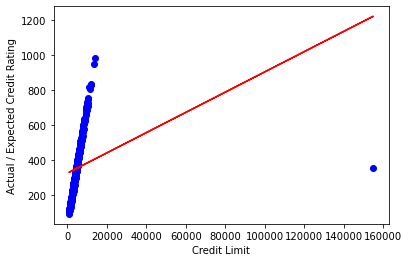

In [13]:
yhat_out = outModel.predict(matCopy)

plt.plot(matCopy[:,1], y, 'bo')
plt.plot(matCopy[:,1], yhat_out, 'r')
plt.xlabel('Credit Limit')
plt.ylabel('Actual / Expected Credit Rating')
plt.show()

## Why the sensitivity?
Recall we are minimizing the sum of squared residuals. That really big outlier is going to a lot of influence.  

## How to combat?
- [RANdom SAmple Consensus (RANSAC)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html)  
- Replace or remove the outliers. 


## RANSAC
- Select random samples. 
- Tests non-sample points and creates a inlier list (opposite of outlier).  
- Refits models with all inliers.  
- Evaluates error.  
- Stops or repeats until iterations/threshold met.
- **Not guaranteed to get same answer each time* - why?**

> [More details](https://scikit-learn.org/stable/modules/linear_model.html#ransac-regression)

<img src='files/diagrams/ransac.png'>

[Image Source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html)

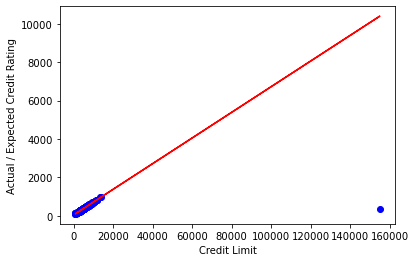

In [14]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor().fit(matCopy, y)
yhat_ransac = ransac.predict(matCopy)

plt.plot(matCopy[:,1], y, 'bo')
plt.plot(matCopy[:,1], yhat_ransac, 'r')
plt.xlabel('Credit Limit')
plt.ylabel('Actual / Expected Credit Rating')
plt.show()

In [16]:
# ransac.inlier_mask_

# Strength: Robust to Overfitting
>Simple is better than complex.

### No Overfitting
<img src='files/diagrams/reg.png'  style="width: 400px;"> 

### Severe Overfitting
<img src='files/diagrams/poly.png'  style="width: 400px;">

# Multiple Regression
Instead of an $mx1$ input matrix, we'll have $mxn$.

### $y = w_{0} + w_{1}x_{1} + \dots + w_{m}x_{m} = \sum{w_{i}x_{i}}=w^{T}x$

Coefficients still reference the effect on $y$ of a 1-unit change to a $x$ - all else held constant.

Example with the California housing dataset:

## California Housing

In [18]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from matplotlib import pyplot as plt
import warnings
%matplotlib inline

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X, y = fetch_california_housing(return_X_y=True, as_frame=True)
    x0, x1 = X.shape

print(f'Rows: {x0:,}\nFeatures: {x1}')

Rows: 20,640
Features: 8


In [19]:
california_df = pd.concat([X,y], axis=1)
california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Run the regression

Need to add a constant/intercept term manually as statsmodels doesn't handle this automatically.

In [20]:
california_df['const'] = 1

featureNames = [x for x in california_df.columns if x != 'MedHouseVal']
# featureNames = ['const'] + list(featureNames)

print(featureNames)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'const']


> Double and triple check that you properly separated your target variable from your features!

In [21]:
import statsmodels.api as smf
statsModelsCoefs = smf.OLS(california_df['MedHouseVal'], california_df[featureNames]).fit()

print(statsModelsCoefs.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Thu, 23 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:23:21   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MedInc         0.4367      0.004    104.054      0.0

## Check Residuals

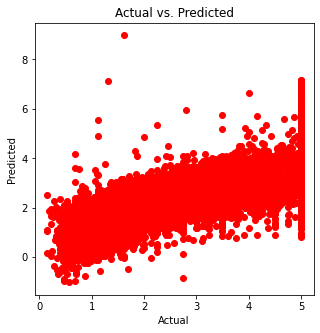

In [22]:
yhat = statsModelsCoefs.predict(california_df[featureNames])
resid = y - yhat

plt.figure(figsize=(5,5))
plt.plot(y, yhat, 'ro')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

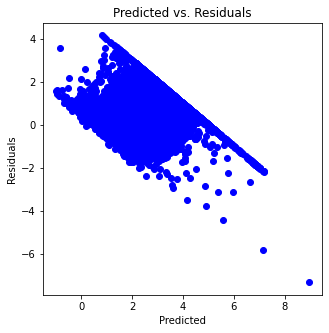

In [23]:

plt.figure(figsize=(5,5))
plt.plot(yhat, resid, 'bo')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs. Residuals')
plt.show()

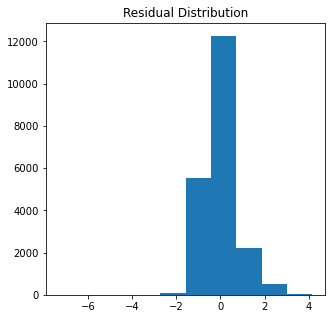

In [24]:
plt.figure(figsize=(5,5))
plt.hist(resid, bins=10)
plt.title('Residual Distribution')
plt.show()

### Patterns in residuals are not ideal. You'll want these to look like normally distributed white noise (ideally). We might be able to make those residuals behave with feature transformations and other techniques we'll talk about later.

>In certain cases, it may help to log-transform your target variable, which will compress some of the variance.

[Log-linear models](https://en.wikipedia.org/wiki/Log-linear_model)

In [25]:
import statsmodels.api as smf
logMV = np.log(california_df['MedHouseVal'])

statsModelsCoefs = smf.OLS(logMV, california_df[featureNames]).fit()
print(statsModelsCoefs.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     4109.
Date:                Thu, 23 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:27:12   Log-Likelihood:                -7819.3
No. Observations:               20640   AIC:                         1.566e+04
Df Residuals:                   20631   BIC:                         1.573e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MedInc         0.1870      0.002     91.271      0.0

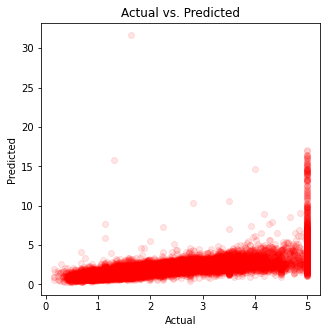

In [26]:
logyhat = statsModelsCoefs.predict(california_df[featureNames])
logresid = logMV - logyhat

plt.figure(figsize=(5,5))
plt.plot(np.exp(logMV), np.exp(logyhat), 'ro', alpha=0.1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

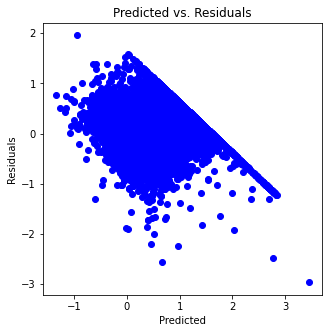

In [27]:
plt.figure(figsize=(5,5))
plt.plot(logyhat, logresid, 'bo')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs. Residuals')
plt.show()

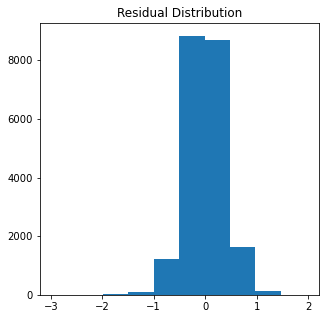

In [28]:
plt.figure(figsize=(5,5))
plt.hist(logresid, bins=10)
plt.title('Residual Distribution')
plt.show()

> We'll go over models later that can catch the tail of this data better.

# What if we had categorical variables?

## Role of [Dummy Variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics))
A way to incorporate categorical data into modeling, since models require numerical matrices. Essentially acts to change the intercept.

### Simple Example

In [29]:
dummy = pd.DataFrame([[2,4,1],
                     [3,6,1],
                     [4,8,1],
                     [6,12,1],
                     [7,14,1],
                     [2,6,0],
                     [4,10,0],
                     [6,14,0],
                     [7,16,0],
                     [3,8,0]], columns=['hgt', 'wgt', 'label'])


dummy

,hgt,wgt,label
0,2,4,1
1,3,6,1
2,4,8,1
3,6,12,1
4,7,14,1
5,2,6,0
6,4,10,0
7,6,14,0
8,7,16,0
9,3,8,0


### Persistent differences between these lines. Track parallel to one another.

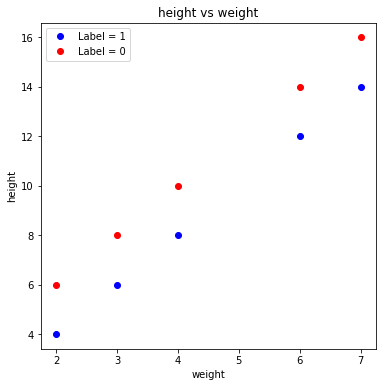

In [30]:
class1 = dummy.query('label==1')
class2 = dummy.query('label==0')

plt.figure(figsize=(6,6))
plt.plot(class1['hgt'], class1['wgt'], 'bo')
plt.plot(class2['hgt'], class2['wgt'], 'ro')
plt.legend(['Label = 1', 'Label = 0'])
plt.title('height vs weight')
plt.ylabel('height')
plt.xlabel('weight')
plt.show()

### Let's look at the means for the data by group

In [31]:
dummy.groupby('label')['wgt'].mean()

label
0    10.8
1     8.8
Name: wgt, dtype: float64

In [32]:
dummy.groupby('label')['wgt'].mean().diff()[1]

-2.0

### Compare running a model with and without a dummy variable

In [33]:
from sklearn.linear_model import LinearRegression

Xa = np.array(dummy['hgt']).reshape(-1,1)
Xb = np.array(dummy[['hgt','label']])

y = np.array(dummy['wgt']).reshape(-1,1)

bothOLS = LinearRegression().fit(Xa,y)
# yhat_both = bothOLS.predict(Xa)

sepOLS = LinearRegression().fit(Xb, y)
# yhat_sep = sepOLS.predict(Xb)

print('No Dummy:\n')
print(f' Intercept: {np.round(bothOLS.intercept_[0],2)}')
print(f' Slope: {np.round(bothOLS.coef_[0][0],2)}\n')

print('w/ Dummy:\n')
print(f' Intercept: {np.round(sepOLS.intercept_[0], 2)}')
print(f' Slope: {np.round(sepOLS.coef_[0][0],2)}')
print(f' Dummy: {np.round(sepOLS.coef_[0][1], 0)}')

No Dummy:

 Intercept: 1.0
 Slope: 2.0

w/ Dummy:

 Intercept: 2.0
 Slope: 2.0
 Dummy: -2.0


In [34]:
points = np.array([1,2,3,4,5,6,7,8])
labels = np.array([0,0,0,0,1,1,1,1])

In [35]:
with_dummy_X = np.stack([points, labels], axis=1)
with_dummy_X

array([[1, 0],
       [2, 0],
       [3, 0],
       [4, 0],
       [5, 1],
       [6, 1],
       [7, 1],
       [8, 1]])

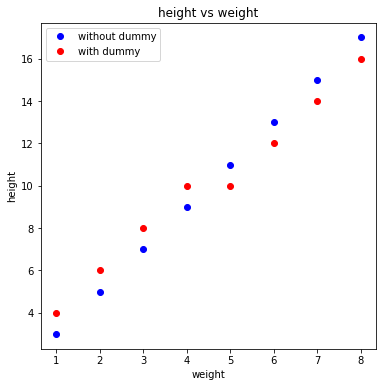

In [36]:
plt.figure(figsize=(6,6))
plt.title('height vs weight')
plt.ylabel('height')
plt.xlabel('weight')

plt.plot(points, bothOLS.predict(points.reshape(-1,1)) ,'bo')
plt.plot(points, sepOLS.predict(with_dummy_X) , 'ro')


plt.legend(['without dummy', 'with dummy'])


plt.show()

### The dummy captures the mean difference! Otherwise the slope is identical.

If the dummy was present:
$$
y=1.0 + (2)(x_1) + (2)(1) 
$$

If the dummy was not present:
$$
y=2.0 + (2)(x_1) + (2)(0)
$$



# Incorporating Categorical Variables into a Model w/ Pipelines
[Example from "Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow"](https://github.com/ageron/handson-ml2)

This is an expanded, rawer form of the california housing data that is available in scikit-learn.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

housing = pd.read_csv('https://github.com/ekacar1/Data_for_Lectures/housing.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


## Goal - Predict Median House Value

#### Things we need to consider:
- Ocean Proximity is categorical. 
- Missing values in Total Bedrooms.  
- Data of significantly different scales.

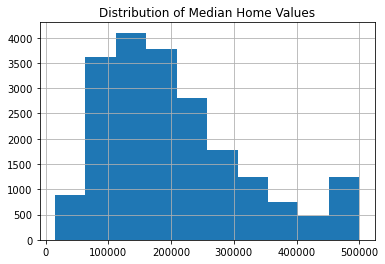

In [38]:
housing.median_house_value.hist()
plt.title('Distribution of Median Home Values')
plt.show()

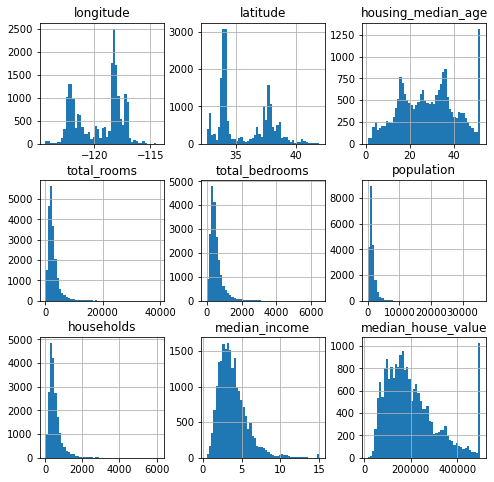

In [39]:
housing.hist(bins=50, figsize=(8,8))
plt.show()

In [40]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Interesting items of note:
- Wide variances in scales. 
- Median house value truncated at $500,000  
- Outliers are present

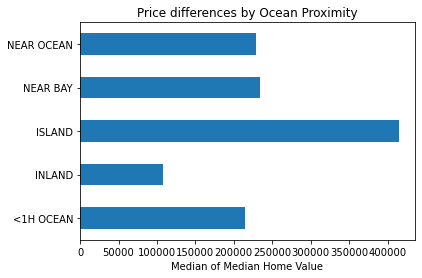

In [41]:
housing.groupby('ocean_proximity')['median_house_value'].median().plot.barh()
plt.xlabel('Median of Median Home Value')
plt.ylabel('')
plt.title('Price differences by Ocean Proximity')
plt.show()

Inland homes have significantly lower prices than homes closer to the water.

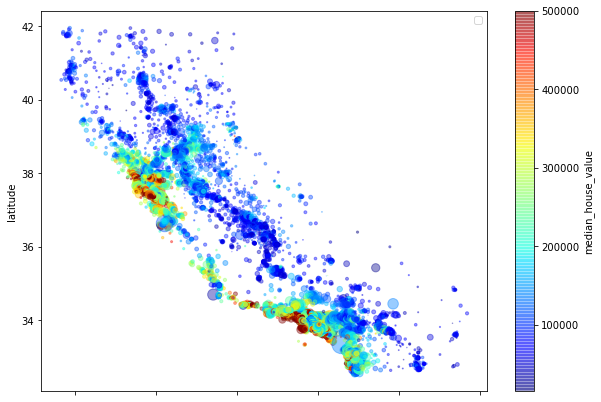

In [42]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100,
            label='population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'),
            colorbar=True)
plt.legend('')
plt.show()

Higher values are largely clustered around the coast.

[Example from "Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow](https://github.com/ageron/handson-ml2)

# Missing Values

#### Options:
- Drop rows (can be bad, what if incoming data has missing values?). 
- Drop columns (could be bad, what if there value in that feature?).  
- Fill in the missing values (ding ding).  
- If categorical, might want to add a dummy to indicate it was missing (ding ding).  
- Best strategy will be situationally dependent. This can be treated as a hyperparameter - no perfect answer.

#### Strategies:
- Simple inputers with median, median, mode, random values.  
- Estimate the missing value with another machine learning model (increasing overal complexity).  

>Not all strategies will work for all data types, so you may need to split it up, e.g., one method for the numerical variables and another for the categorical variables.

In [43]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

### Filling with median

In [44]:
from sklearn.impute import SimpleImputer

example_imputer = SimpleImputer(strategy='median')
example_imputer.fit_transform(housing.total_bedrooms.to_numpy().reshape(-1,1))
# example_imputer.fit(housing.total_bedrooms.to_numpy().reshape(-1,1))
# example_imputer.transform(housing.total_bedrooms.to_numpy().reshape(-1,1))

example_imputer

SimpleImputer(strategy='median')

In [45]:
imputed = example_imputer.transform(housing.total_bedrooms.to_numpy().reshape(-1,1))
imputed

array([[ 129.],
       [1106.],
       [ 190.],
       ...,
       [ 485.],
       [ 409.],
       [ 616.]])

In [46]:
pd.Series(np.squeeze(imputed)).isna().sum()

0

In [47]:
example_imputer.transform(np.array([100,10, None]).reshape(-1,1))

array([[100.],
       [ 10.],
       [435.]])

### If you wanted to add an indictor for the missing value
> Probably more useful for categorical variables

In [48]:
from sklearn.impute import SimpleImputer

example_imputer = SimpleImputer(strategy='median', add_indicator=True)
imputed_bedroom_with_ind = example_imputer.fit_transform(np.array(housing.total_bedrooms).reshape(-1,1))
imputed_bedroom_with_ind

array([[ 129.,    0.],
       [1106.,    0.],
       [ 190.,    0.],
       ...,
       [ 485.,    0.],
       [ 409.,    0.],
       [ 616.,    0.]])

In [49]:
pd.DataFrame(imputed_bedroom_with_ind, columns=['total_bedrooms', 'missing']).query('missing==1').head()

,total_bedrooms,missing
290,435.0,1.0
341,435.0,1.0
538,435.0,1.0
563,435.0,1.0
696,435.0,1.0


In [50]:
housing.iloc[[290, 341, 342], :]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
290,-122.16,37.77,47,1256,NaN,570,218,4.3750,NEAR BAY,161900
341,-122.17,37.75,38,992,NaN,732,259,1.6196,NEAR BAY,85100
342,-122.18,37.75,45,990,261.0,901,260,2.1731,NEAR BAY,82000


### Note on One-Hot Encoding

From "Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow":
> If a categorical attribute has a large number of possible categories, then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance.

#### Possible alternatives in that situation:
- Recode to a numerical feature, e.g., distance to ocean.  
- Only use the most frequent $N$ categories.  
- Convert to embeddings.  

#### A risk for us:
May not have any islands in the training data, what would happen if we encountered that in our test/evaluation data?

In [51]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Islands are really rare

- Adding a dummy for this won't do much - it'll basically be zero.  
- Replace to nearest category?

In [52]:
from sklearn.preprocessing import OneHotEncoder

example_ohe = OneHotEncoder()
housing_ohe_transformed = example_ohe.fit_transform(np.array(housing['ocean_proximity']).reshape(-1,1))
housing_ohe_transformed

<20640x5 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>

> Sparse matrix returns lists of coordinates in the matrix with a non-zero. It's a more efficient structure:

In [53]:
print(housing_ohe_transformed[:5,])

  (0, 3)	1.0
  (1, 3)	1.0
  (2, 3)	1.0
  (3, 3)	1.0
  (4, 3)	1.0


>Can be converted back to a dense format:

In [54]:
housing_ohe_transformed.toarray()[:5,:]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [55]:
pd.DataFrame(housing_ohe_transformed.toarray()[:5], columns=example_ohe.categories_,dtype='int')

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


### Should we use this for modeling?

>In statistics, multicollinearity (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation, the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.
<br><br>[Wikipedia](https://en.wikipedia.org/wiki/Multicollinearity)

### Could argue that this could be represented as an ordinal variable (island > near ocean > near bay > ...)
See [OrdinalEncoder for as example](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

You could try this using both methods to see if one is better.

# A Brief Rant on LabelEncoder
Should not be used on your feature set! This is commonly done on Kaggle (incorrectly!). Do not use this for your feature processing! This is for __target__ variable.

[LabelEncoder Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html?highlight=labelencoder)

# Scaling Numerical Variables
__Don't skip this__ - most models don't perform well when variables are on different scales.

In [56]:
housing.select_dtypes(['float','integer']).describe().round(0)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.0,20640.0,20640.0,20640.0,20433.0,20640.0,20640.0,20640.0,20640.0
mean,-120.0,36.0,29.0,2636.0,538.0,1425.0,500.0,4.0,206856.0
std,2.0,2.0,13.0,2182.0,421.0,1132.0,382.0,2.0,115396.0
min,-124.0,33.0,1.0,2.0,1.0,3.0,1.0,0.0,14999.0
25%,-122.0,34.0,18.0,1448.0,296.0,787.0,280.0,3.0,119600.0
50%,-118.0,34.0,29.0,2127.0,435.0,1166.0,409.0,4.0,179700.0
75%,-118.0,38.0,37.0,3148.0,647.0,1725.0,605.0,5.0,264725.0
max,-114.0,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500001.0


## Two main methods:
> Only fit these to the training data, no leaking information from the test set!


### Min-max scaling
- Simple  
- Bound between 0 and 1 - a lot of algorithms like that, especially neural networks
- scikit-learn gives you some additional flexibility in terms of the range  
- Very susceptible to outliers

$$
x_{scaled} = \frac{x - x_{min}}{x_{max}-x_{min}}
$$

### Standardization
- Little more involved. 
- More robust to outliers. 
- No specific range boundary. 

$$
x_{scaled} = \frac{x - \hat{x}}{\sigma_{x}}
$$

Since we are doing regression and don't have a scaling boundary requirement and there are probably outliers, we'll use standardization.

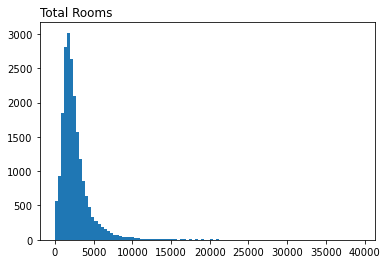

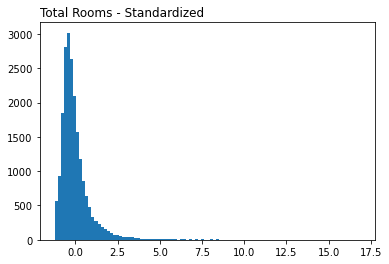

In [57]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

example_SS = StandardScaler()
scaled_total_rooms = example_SS.fit_transform(np.array(housing.total_rooms).reshape(-1,1))

plt.hist(housing.total_rooms, bins=100)
plt.title('Total Rooms', loc='left')
plt.show()

plt.hist(scaled_total_rooms, bins=100)
plt.title('Total Rooms - Standardized', loc='left')
plt.show()

# Training/Test Splits

>Put the test data aside and never look at it again.

- All of the feature transformations and model training should be on the training data.  
- In production, you wouldn't exactly know what the incoming data would look like ahead of time.  
- If you use the test data to inform **any** of the feature transformations or modeling, then you are letting that test data leak into the training data and that will (may) bias your evaluations. This is called **leakage** or **data snooping** - both are not good.

### Simpliest form is splitting your data into two parts:
- Training: will base feature transforms and modeling on this. 
- Test: evaluate the models on this data. 

>There are more robust methods that we'll talk about later. You can think of this simple splitting as a quick and dirty way to evaluate performance, but it isn't a methodology you'd want to use to estimate what your performance is truly likely to be.

### Split off the features and the target variable

In [58]:
y = housing.median_house_value

features = ['housing_median_age', 'total_rooms', 'total_bedrooms', 
            'population', 'households', 'median_income', 'ocean_proximity', 'longitude', 'latitude'
           ]

X = housing[features]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   housing_median_age  20640 non-null  int64  
 1   total_rooms         20640 non-null  int64  
 2   total_bedrooms      20433 non-null  float64
 3   population          20640 non-null  int64  
 4   households          20640 non-null  int64  
 5   median_income       20640 non-null  float64
 6   ocean_proximity     20640 non-null  object 
 7   longitude           20640 non-null  float64
 8   latitude            20640 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 1.4+ MB


### Split into training and test sets
>80/20 split is pretty standard, but not universal. For very large datasets, I've heard of 99/1 splits.

In [59]:
from sklearn.model_selection import train_test_split

X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.20)

print(f'Training samples: {X_training.shape[0]:,}')
print(f'Test samples: {X_test.shape[0]:,}')

Training samples: 16,512
Test samples: 4,128


>Remember, the test data is only for evaluation.

In [60]:
X_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 10017 to 15552
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   housing_median_age  16512 non-null  int64  
 1   total_rooms         16512 non-null  int64  
 2   total_bedrooms      16349 non-null  float64
 3   population          16512 non-null  int64  
 4   households          16512 non-null  int64  
 5   median_income       16512 non-null  float64
 6   ocean_proximity     16512 non-null  object 
 7   longitude           16512 non-null  float64
 8   latitude            16512 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 1.3+ MB


# Pipelines

- Fill missing values. 
- Create dummies for categorical.  
- Standardize numerical variables.  
- Fit the model.  

### Pipelines can be made of collections of pipelines

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_vars = ['ocean_proximity']
num_vars = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
            'households', 'median_income', 'longitude', 'latitude']

num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])

cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, num_vars),
                                                      ('create_dummies', cat_pipeline, cat_vars)])

print(processing_pipeline)

ColumnTransformer(transformers=[('proc_numeric',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['housing_median_age', 'total_rooms',
                                  'total_bedrooms', 'population', 'households',
                                  'median_income', 'longitude', 'latitude']),
                                ('create_dummies',
                                 Pipeline(steps=[('impute_missing_cats',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncoder(drop='first',
                                                              

In [62]:
from sklearn.linear_model import LinearRegression

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), 
                              ('lm', LinearRegression())
                             ])
modeling_pipeline.fit(X_training, y_training)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income', 'longitude',
                                                   'latitude']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('lm', LinearRegression())])

In [ ]:
# modeling_pipeline.fit(X_training, y_training)

# Evaluating the model
>Really evaluatign the entire preprocessing process and the model itself.

In [63]:
housing_predictions = modeling_pipeline.predict(X_test)

### Get the mean squared error, root mean squared error, and $R^2$

In [64]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, housing_predictions)
mse

4719823996.629959

In [65]:
rmse = np.sqrt(mse)
rmse

68700.97522328165

In [66]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, housing_predictions)
r2

0.6455268466443493

### Plot the test and predictions

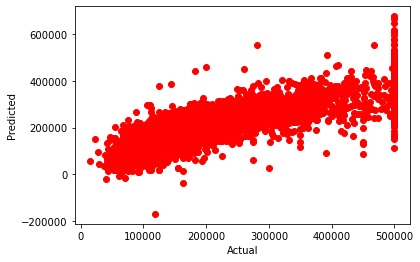

In [67]:
import matplotlib.pyplot as plt

plt.plot(y_test, housing_predictions, 'ro')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

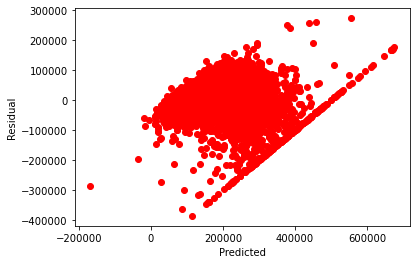

In [68]:
plt.plot(housing_predictions, housing_predictions - y_test, 'ro')
plt.ylabel('Residual')
plt.xlabel('Predicted')
plt.show()

# Observations
- If this was a perfect model, the residuals would be 0 for all actual/predicted values.  
- Residuals should look like white noise across all values - seeing some patterns.  
- Some information is leaking into the residuals that the model is capturing.  
    - Could be a feature we don't have access to.  
    - Could be noise in the data.  
    - Could be the underlying relationships are linear.  
    - Insert any number of additional explanations.  
    
There may be some overfitting - the training data fits better than the test data. We can explore other models to see if they are able to reduce the overfitting.

# Bias-variance Tradeoff

<img src='files/diagrams/bullseye.png' style="width: 600px;">

[Image source](http://scott.fortmann-roe.com/docs/BiasVariance.html)

>At its root, dealing with bias and variance is really about dealing with **over- and under-fitting**. Bias is reduced and variance is increased in relation to model complexity. As more and more parameters are added to a model, the complexity of the model rises and variance becomes our primary concern while bias steadily falls
<br><br>Understanding the Bias-Variance Tradeoff, Fortmann-Roe


From Raschka (paraphrased):
>Variance measures the consistency (or variability) of the model prediction. If we retrain the model on different subsets of the training get and observe difference results, we say it is subject to high variance.

>Bias measures how far off the predictions are from the correct values. This will be error that isn't due to differences in the training datasets.

[Bias and variance from Raschka's Evaluation Lecture Notes](https://sebastianraschka.com/pdf/lecture-notes/stat479fs18/08_eval-intro_notes.pdf)


<img src='files/diagrams/high-bias.png' style="width: 600px;">


<img src='files/diagrams/high-variance.png' style="width: 600px;">

# Simple Usually Triumphs Over the Complex
It's a balancing act though. You'll need a minimum level of complexity to capture the relationships in the data.

<img src='files/diagrams/biasvariance.png'>

[Image source](http://scott.fortmann-roe.com/docs/BiasVariance.html)

## Potential Options
- Include less features.  
- Shrinkage methods.  
- Data over models.  

# Low Variance, Forward, and Backward Selection

## [Low Variance](https://scikit-learn.org/stable/modules/feature_selection.html)
>You can automatically omit features with zero-variance (i.e., constants).

In [69]:
from sklearn.feature_selection import VarianceThreshold
X = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]])
print(X)

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 1]
 [0 1 0]
 [0 1 1]]


In [70]:
sel = VarianceThreshold(threshold=0.16)
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

## [Forward or Backward Selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)

From scikit-learn:
>Forward-SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero feature and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the n_features_to_select parameter.

>Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set. The direction parameter controls whether forward or backward SFS is used.
<br><br>In general, forward and backward selection do not yield equivalent results. Also, one may be much faster than the other depending on the requested number of selected features: if we have 10 features and ask for 7 selected features, forward selection would need to perform 7 iterations while backward selection would only need to perform 3.

>SFS differs from RFE and SelectFromModel in that it does not require the underlying model to expose a coef_ or feature_importances_ attribute. It may however be slower considering that more models need to be evaluated, compared to the other approaches. For example in backward selection, the iteration going from m features to m - 1 features using k-fold cross-validation requires fitting m * k models, while RFE would require only a single fit, and SelectFromModel always just does a single fit and requires no iterations.

[See a *Comparative Study of Techniques for Large-Scale Feature Selection* for more discussion.](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.24.4369&rep=rep1&type=pdf)

### Basic Idea
- Start with all the features. 
- Determine the feature provided the least added benefit.    
- Remove the above feature.  
- Continue until reach the desired number of features or hit a threshold.  

### Rational
> Automatically select the most relevant subset of features.  

> Really only necessary if your models don't support regularization.

> Can help with the *Curse of Dimensionality* since it'll generally select a more parsimonious model with dense features.

From Machine Learning with Python, SBS (backward) showed a model with 3 features would have achieved 100% accuracy on the validation data set. See pages 137-139.
<img src='files/diagrams/04_08.png' style='width: 300px;'>

[Image source - Raschka's GitHub; Python for Machine Learning 3rd Edition, Figure 4.8](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch04/images/04_08.png)


- I've never used these in practice - there are other ways to guard against overfitting and selecting a more parsimonious model.  
- Can add a lot of computational overhead.  

[See an example from scikit-learn for code example.](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py)

# Regularization
>Helps solve overfitting (high variance) - having too many parameters (i.e., too complex).  

>Also helps with multicolinearity (which we saw) and filtering out noise.  

### Types of regularization:
- $L1$ (lasso - least absolute shrinkage and selection operator): penalizing the sum of $\lvert \beta_{j} \rvert$  
- $L2$ (ridge): penalizing the sum of the $\beta_{j}$'s

# Shrinkage with Ridge Regression ($l_2$ Regularization)
## We can modify our loss function to penalize complexity
Shrinking parameter values to penalize for increased complexity (i.e., parameters with meaningful weights).
>Shrinks, but does not eliminate. Coefficients will be non-zero. Will that help when there any many many features?

## Reduces the influence of parameters that carry less weight

Recall $\hat\beta = (X^TX)^{-1}X^{T}y$  
Goal: $\frac{1}{N}\sum{\epsilon_{i}^2}$

#### We can force parameters to shrink towards zero, effectively reducing their influence by adding a penality to the loss function:
$argmin\frac{1}{N}\sum{\epsilon_{i}^2} + \sum{\lambda\beta_{j}^2}$
- What happens with $\lambda=0$?

New closed form: $\hat\beta = (X^TX+\lambda{I})^{-1}X^{T}y$ 

> Ridge has a unique solution, similar to OLS. You can modify the closed form implementation from last class as an independent proof. scikit-learn's implementation uses various optimization methods to solve the loss optimization problem, so it won't be 100% comparable to OLS with $\alpha=0$, it'll be close though.

## Introduces $\lambda$ - our first (official) hyperparameter!
$\lambda$ controls the amount of the penality, it is bounded between 0 and $\infty$.
>When $\lambda=0$, ridge will provide the same coefficients as OLS, since the $\lambda{I}$ will become zero.

In [71]:
from sklearn.linear_model import Ridge

modeling_pipeline_ridge = Pipeline([('data_processing', processing_pipeline), ('ridge', Ridge(alpha=0))])
modeling_pipeline_ridge.fit(X_training, y_training)
modeling_pipeline_ridge['ridge'].coef_

array([ 13323.86587756, -10118.87552741,  31144.9690616 , -42139.62000071,
        26284.83341184,  73805.41398676, -51434.39223355, -52320.75282217,
       -40454.05651858, 155700.32149863,  -4162.94801668,   5668.12550629])

> Compared to the below from the original model:

In [72]:
modeling_pipeline['lm'].coef_

array([ 13323.86587756, -10118.87552741,  31144.9690616 , -42139.62000071,
        26284.83341184,  73805.41398676, -51434.39223355, -52320.75282217,
       -40454.05651858, 155700.32149863,  -4162.94801668,   5668.12550629])

# Now to evaluate different $\lambda$ values
>We'll need to evaluate a gradient of $\lambda$ values to determine the best one to use.

In [73]:
from collections import defaultdict
alphas = [0, 1, 2, 5, 10, 50]

ridge_results = defaultdict(dict)

for alph in alphas:
    modeling_pipeline_ridge = Pipeline([('data_processing', processing_pipeline), ('ridge', Ridge(alpha=alph))])
    modeling_pipeline_ridge.fit(X_training, y_training)
    ridge_results['coefficients'][alph] = modeling_pipeline_ridge['ridge'].coef_
    ridge_results['training score'][alph] = modeling_pipeline_ridge.score(X_training, y_training)
    ridge_results['test score'][alph] = modeling_pipeline_ridge.score(X_test, y_test)

print('Done')

Done


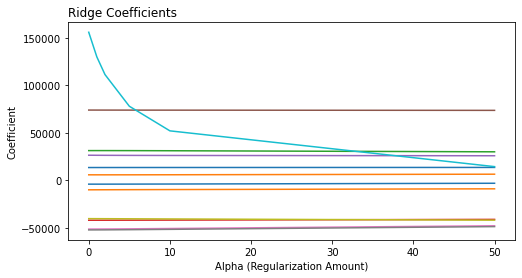

In [74]:
coefficients_ridge = pd.DataFrame.from_dict(ridge_results['coefficients'])
coefficients_ridge = coefficients_ridge.reset_index()
coefficients_ridge = coefficients_ridge.rename(columns={'index':'coefficient_nbr'})
coefficients_ridge = coefficients_ridge.melt(id_vars='coefficient_nbr', var_name='alpha', value_name='coefficient')

(
coefficients_ridge.pivot_table(index='alpha', columns='coefficient_nbr', values='coefficient')
    .plot(figsize=(8,4),legend=False)
)

plt.title('Ridge Coefficients', loc='left')
plt.xlabel('Alpha (Regularization Amount)')
plt.ylabel('Coefficient')
plt.show()

### Changes in $R^2$

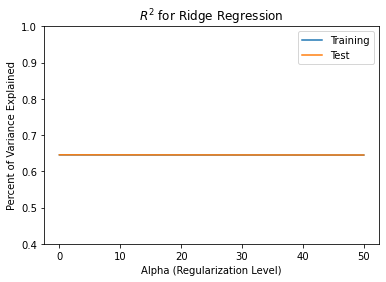

In [75]:
ridge_training_r2 = pd.Series(ridge_results['training score'])
ridge_test_r2 = pd.Series(ridge_results['test score'])

ridge_training_r2.plot()
ridge_test_r2.plot()
plt.title('$R^2$ for Ridge Regression')
plt.legend(['Training','Test'])
plt.xlabel('Alpha (Regularization Level)')
plt.ylabel('Percent of Variance Explained')
plt.ylim(0.4, 1)
plt.show()

# Another Option is Lasso - Requires Gradient Descent (GD)
OLS and Ridge regression have unique solutions (even though scikit-learn uses optimization). In order to talk about some of the other variants, we need to talk about an optimization technique called gradient descent.

Gradient descent is an optimization technique that allows us to "learn" what the coefficients should be by iteration and continuous improvment. Traditional statisticans don't love this technique since it's not too far away from guessing a bunch of times until you can't guess much better.  

<img src='files/diagrams/gs.png' style="width: 300px;">

[Image source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.datasciencecentral.com%2Fprofiles%2Fblogs%2Falternatives-to-the-gradient-descent-algorithm&psig=AOvVaw1ki8gWYTrWRy-NKpu7RFgo&ust=1631036623607000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCJiSq6nz6vICFQAAAAAdAAAAABAD)

Gradient descent essentially is looking for the local minimums of loss functions that are differentiable.  

While least-squares does not a closed-form solution, you can also approximate it using gradient descent. Gradient descent will reappear with other algorithms.

GD requires a loss function, which for OLS regression is the sum of squared errors:
$$J(w)=\frac{1}{2}\sum(y^{(i)} - \hat{y}^{(i)})^2$$

This also be used in logistic regression and neural networks.

## Updating weights
All of the weights are set simultaneously.

1. Initialize weights to 0 or small random numbers. 
2. For each training example, $x^{i}$:  
    a. Compute the output value, $\hat{y}$.  
    b. Update the weights.

In [76]:
def gradientDescent(x, y, theta, alpha, m, numIterations):
    thetaHistory = list()
    
    xTrans = x.transpose()
    costList = list()
    
    for i in range(0, numIterations):
        # data x feature weights = y_hat
        hypothesis = np.dot(x, theta)
        # how far we are off
        loss = hypothesis - y 
        # mse
        cost = np.sum(loss ** 2) / (2 * m)
        costList.append(cost)

        # avg gradient per example
        gradient = np.dot(xTrans, loss) / m 

        # update
        theta = theta - alpha * gradient
        thetaHistory.append(theta)
        
    return thetaHistory, costList

### Create training data

In [77]:
data_pipeline = Pipeline([('data_processing', processing_pipeline)])
data_pipeline.fit(X_training)

gs_training_data = data_pipeline.fit_transform(X_training)

### Run the model

Completed in 0:00:06.999440


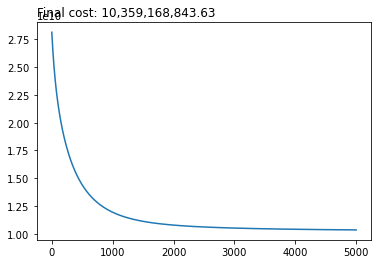

In [78]:
import datetime

start_ts = datetime.datetime.now()
betaHistory, costList = gradientDescent(gs_training_data,y_training,
                                        theta=np.zeros(gs_training_data.shape[1]),
                                        alpha=0.01,
                                        m=gs_training_data.shape[0], numIterations=5000)
                                                                 
end_ts = datetime.datetime.now()

print(f'Completed in {end_ts-start_ts}')

plt.plot(costList)
plt.title(f'Final cost: {costList[-1]:,.2f}', loc='left')
plt.show()

## Show changes in $\beta$ throughout the iterations

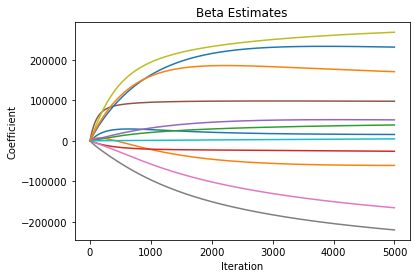

In [79]:
from collections import defaultdict
thetas = defaultdict(list)

for i in range(len(betaHistory)):
    for j in range(len(betaHistory[i])):
        thetas[j].append(betaHistory[i][j])
        
thetasD = pd.DataFrame.from_dict(thetas)
thetasD.plot(legend=False)
plt.title('Beta Estimates')
plt.ylabel('Coefficient')
plt.xlabel('Iteration')
plt.show()

### Predictions

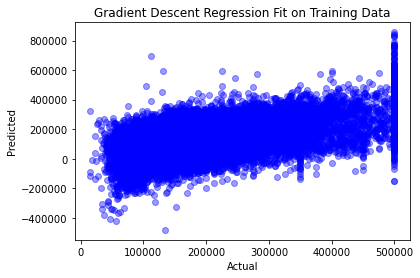

In [80]:
gs_betas = betaHistory[4999]
gs_predictions = np.dot(gs_training_data, gs_betas)

plt.plot(y_training, gs_predictions, 'bo', alpha=0.4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Descent Regression Fit on Training Data')
plt.show()

# Where things can go wrong:
- The learning rate (alpha generally) is really important. If you pick a rate that is too large, you may hop over the minimum and the models will either be very poor or never converge.  
- Other thresholds may take some trial and error.  
- You can get stuck at a local minima and never find the global minima.  
- You need to know when to stop. It'll keep adjusting coefficients until it reaches an iteration limit or a derivative threshold. Too long and overfitting could occur.

# Lasso Regression ($l_1$ Regularization)
No closed form solution - will need to use optimization techniques regardless.  

$$
J(w)_{lasso}=\sum{(y^{(i)}-\hat{y}^{(i)})^2+\lambda \lvert \lvert w \rvert \rvert_1}
$$

$$
L1:\lambda \lvert \lvert w \rvert \rvert_1 = \lambda \sum{\lvert w_j \rvert}
$$

Could modify the gradient descent with the above, but we'll let sci-kit learn handle it.

## Differences from Ridge

<img src='files/diagrams/ridge-v-lasso.png'>

[Introduction to Statistical Learning, Figure 3.11](https://www.statlearning.com)
>Estimation picture for the lasso (left) and ridge regression (right). Shown are contours of the error and constraint functions. The solid blue areas are the constraint regions $\lvert \beta_1 \rvert \leq t$ and $\beta_{1}^2 + \beta_{2}^2 \leq t^2$, respectivity, while the red ellipses are the contours of the least squares error function.

#### Explanation from Raschka (Python Machine Learning 3rd Edition, Chapter 4, pages 129-131):
> We can think of regularization as adding a penalty term to the cost function to encourage smaller weighs; in other words, we penalize large weights. Thus, by increasing the regularization strength via the regularization parameter, we shrink the weights toward zero and decrease the dependence of our model on the training data.

> The shaded regions of represent the regularization "budget" - the combination of the weights cannot exceed those limits. As the regularization term increases, so does the area of that shaded region.

[See Elements of Statistical Learning Section 3.4 for a more thorough discussion.](https://web.stanford.edu/~hastie/ElemStatLearn/)

### TL:DR - Lasso can create sparse models, Ridge cannot.
Ridge will have non-zero estimates for its $\beta$ values, and lasso can result in some $\beta$ values equal to zero (i.e., sparse).

- Lasso should provide better protection to overfitting than Ridge and OLS.  
- Can also be a technique by itself for feature selection.  

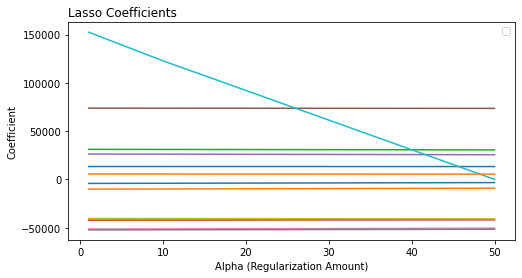

In [81]:
from sklearn.linear_model import Lasso
from collections import defaultdict

alphas = [1, 2, 5, 10, 50]

lasso_results = defaultdict(dict)

for alph in alphas:
    modeling_pipeline_lasso = Pipeline([('data_processing', processing_pipeline), ('lasso', Lasso(alpha=alph))])
    modeling_pipeline_lasso.fit(X_training, y_training)
    lasso_results['coefficients'][alph] = modeling_pipeline_lasso['lasso'].coef_
    lasso_results['training score'][alph] = modeling_pipeline_lasso.score(X_training, y_training)
    lasso_results['test score'][alph] = modeling_pipeline_lasso.score(X_test, y_test)
    
coefficients_lasso = pd.DataFrame.from_dict(lasso_results['coefficients'])
coefficients_lasso = coefficients_lasso.reset_index()
coefficients_lasso = coefficients_lasso.rename(columns={'index':'coefficient_nbr'})
coefficients_lasso = coefficients_lasso.melt(id_vars='coefficient_nbr', var_name='alpha', value_name='coefficient')

coefficients_lasso.pivot_table(index='alpha', columns='coefficient_nbr', values='coefficient').plot(figsize=(8,4))
plt.title('Lasso Coefficients', loc='left')
plt.xlabel('Alpha (Regularization Amount)')
plt.ylabel('Coefficient')
plt.legend('')
plt.show()

In [82]:
coefficients_ridge.query('coefficient_nbr == 9')

,coefficient_nbr,alpha,coefficient
9,9,0,155700.321499
21,9,1,129721.016719
33,9,2,111179.530158
45,9,5,77836.360842
57,9,10,51930.016579
69,9,50,14279.019337


In [83]:
coefficients_lasso.query('coefficient_nbr == 9')

,coefficient_nbr,alpha,coefficient
9,9,1,152399.090206
21,9,2,149097.876339
33,9,5,139194.294414
45,9,10,122688.428443
57,9,50,0.000000


> Lasso shrunk to $0$ and ridge did not!

# Reading

[Spurious correlations (High $r^2$ useless relationships)](https://www.tylervigen.com/spurious-correlations)
<br>[Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
<br>[Additional examples from statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html)
<br> [Common pitfalls](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)
<br>[Andrew Ng on Regularization](https://www.youtube.com/watch?v=NyG-7nRpsW8&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=6)
<br>[Great notes from Goker Erdogan](https://github.com/gokererdogan/JaverianaMLCourse/blob/master/Lectures/05.pdf).
<br>[Raschka on Regularization Performance](https://sebastianraschka.com/faq/docs/regularized-logistic-regression-performance.html)
<br>[Raschka's Linear Regression Notes](http://rasbt.github.io/mlxtend/user_guide/regressor/LinearRegression/)

From Raschka's post:
>Regularization does NOT improve the performance on the data set that the algorithm used to learn the model parameters (feature weights). However, it can improve the generalization performance, i.e., the performance on new, unseen data, which is exactly what we want.